## Import Packages

In [4]:
import glob
import pandas as pd
import cv2
import gc
import numpy as np
import random
import imageio
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

## Configuration

In [5]:
class CFG:
    epochs = 10
    batch_size = 32
    classes = ["ApplyEyeMakeup", "ApplyLipstick", "Archery"]

## Helper Functions

In [6]:
def format_frames(frame, output_size):
    """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
    """
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
    """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      A NumPy array of frames in the shape of (n_frames, height, width, channels).
    """
    # Read each video frame by frame
    result = []
    src = cv2.VideoCapture(str(video_path))  

    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    # ret is a boolean indicating whether read was successful, frame is the image itself
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frames(frame, output_size)
            result.append(frame)
        else:
            result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)[..., [2, 1, 0]]

    return result

def to_gif(images):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images, fps=10)
    return tf.io.gfile.GFile('./animation.gif', 'rb').read()

## Import dataset
### Load videos of selected classes from this dataset.

In [7]:
file_paths = []
targets = []
for i, cls in enumerate(CFG.classes):
    sub_file_paths = glob.glob(f"/kaggle/input/ucf101/UCF101/UCF-101/{cls}/**.avi")
    file_paths += sub_file_paths
    targets += [i] * len(sub_file_paths)

## Visualize video data
#### We will take 10 frames from a video, resize to image size (224, 224), and convert to a GIF file for visualization.

In [10]:
sample_video = frames_from_video_file(file_paths[0], n_frames = 10)
print(sample_video.shape)
gif_bytes = to_gif(sample_video)

(10, 224, 224, 3)


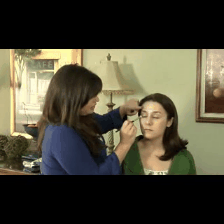

In [29]:
from IPython.display import display, Image

display(Image(gif_bytes))

## Create Training and Validation dataset

In [11]:
features = []
for file_path in tqdm(file_paths):
    features.append(frames_from_video_file(file_path, n_frames = 10))
features = np.array(features)

  0%|          | 0/404 [00:00<?, ?it/s]

In [12]:
train_features, val_features, train_targets, val_targets = train_test_split(features, targets, 
                                                                            test_size=0.2, 
                                                                            random_state=42)
train_features.shape, val_features.shape, len(train_targets), len(val_targets)

((323, 10, 224, 224, 3), (81, 10, 224, 224, 3), 323, 81)

In [13]:
train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_targets)).shuffle(CFG.batch_size * 4).batch(CFG.batch_size).cache().prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((val_features, val_targets)).batch(CFG.batch_size).cache().prefetch(tf.data.AUTOTUNE)

## Delete unused data to release memory.

In [14]:
del train_features
del val_features
gc.collect()

41

## check the shape of the first batch from our training dataset:

In [15]:
for X, y in train_ds.take(1):
    print(X.shape, y.shape)

(32, 10, 224, 224, 3) (32,)


## Modeling with Conv3D
### Create a simple Conv3D baseline Model.

In [16]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(10, 224, 224, 3)),
    tf.keras.layers.Conv3D(32, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling3D(),
    tf.keras.layers.Conv3D(64, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling3D(),
    tf.keras.layers.Conv3D(128, kernel_size=3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling3D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(len(CFG.classes), activation="softmax")
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 224, 224, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 112, 112, 32)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 112, 112, 64)   55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 2, 56, 56, 64)    0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 2, 56, 56, 128)    221312    
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 1, 28, 28, 128)   0

## Visualize the model.

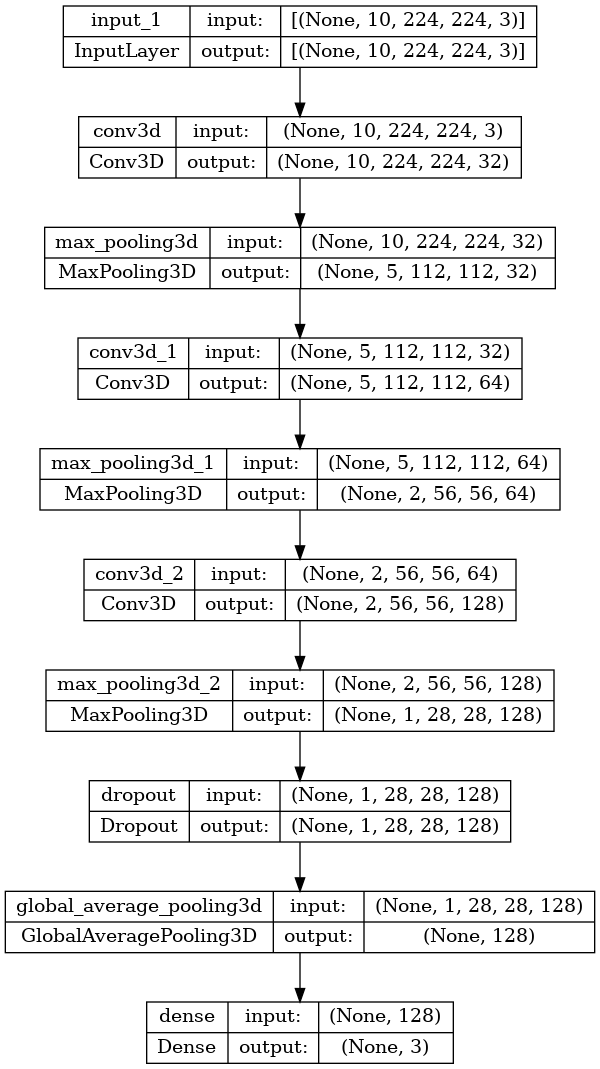

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Train the Model
### Train the model for 30 epochs and save the best model using the ModelCheckpoint callback.

In [18]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5", 
    monitor="val_accuracy",
    mode="max",
    save_best_only=True, 
    restore_best_weights=True
)

history = model.fit(
    train_ds, 
    epochs=30, 
    validation_data=valid_ds, 
    callbacks=[checkpoint]
)

model.load_weights("model.h5")

Epoch 1/30
11/11 [==============================] - 16s 701ms/step - loss: 1.0783 - accuracy: 0.3591 - val_loss: 1.0645 - val_accuracy: 0.7284
Epoch 2/30
11/11 [==============================] - 6s 552ms/step - loss: 1.0961 - accuracy: 0.3870 - val_loss: 1.0761 - val_accuracy: 0.5802
Epoch 3/30
11/11 [==============================] - 6s 551ms/step - loss: 1.0574 - accuracy: 0.4613 - val_loss: 1.0264 - val_accuracy: 0.5185
Epoch 4/30
11/11 [==============================] - 6s 551ms/step - loss: 1.0769 - accuracy: 0.4025 - val_loss: 1.0162 - val_accuracy: 0.3704
Epoch 5/30
11/11 [==============================] - 6s 551ms/step - loss: 0.9812 - accuracy: 0.5139 - val_loss: 0.9122 - val_accuracy: 0.5679
Epoch 6/30
11/11 [==============================] - 6s 551ms/step - loss: 0.9001 - accuracy: 0.5511 - val_loss: 0.7824 - val_accuracy: 0.6790
Epoch 7/30
11/11 [==============================] - 6s 555ms/step - loss: 0.8297 - accuracy: 0.5975 - val_loss: 0.7296 - val_accuracy: 0.7654
Epoch

## Plot learning Curve of Conv3D Model.

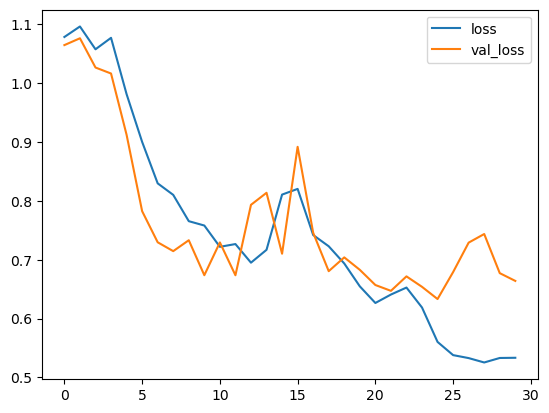

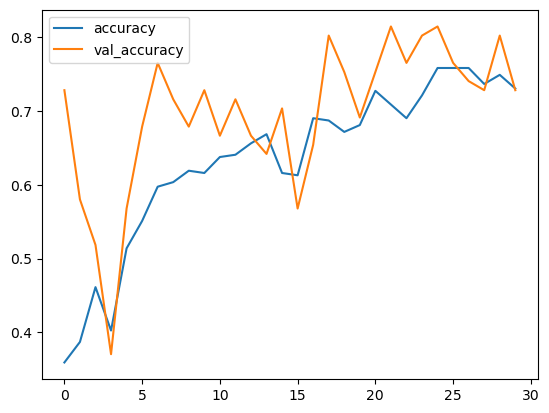

In [19]:
for metrics in [("loss", "val_loss"), ("accuracy", "val_accuracy")]:
    pd.DataFrame(history.history, columns=metrics).plot()
    plt.show()

## Evaluate the Conv3D Model.

In [20]:
val_loss, val_acc = model.evaluate(valid_ds)
print(f"Validation Loss: {val_loss} Validation Accuracy: {val_acc}")

3/3 [==============================] - 1s 172ms/step - loss: 0.6471 - accuracy: 0.8148
Validation Loss: 0.6471010446548462 Validation Accuracy: 0.8148148059844971


## Modeling with EfficientNet
### Now create a Model based on EfficientNet pretrained model.

In [23]:
net = tf.keras.applications.EfficientNetB0(include_top=False)
net.trainable = False

efficient_net_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(255.0),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(len(CFG.classes), activation="softmax")
])

efficient_net_model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])

## Visualize the EfficientNet Model.

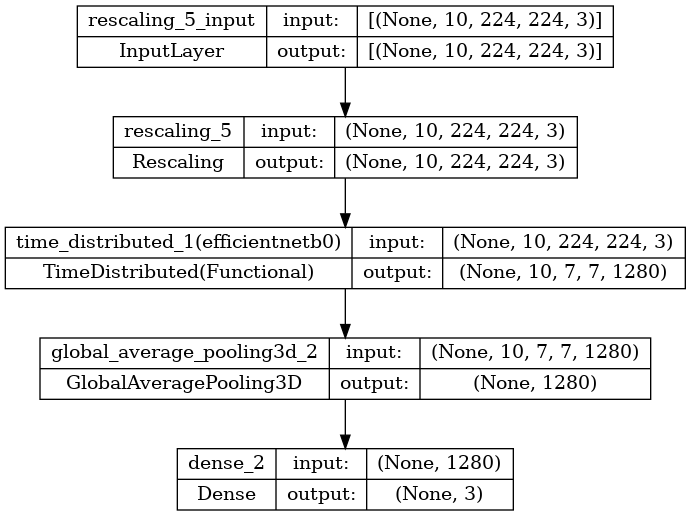

In [25]:
# Build the model by providing an input shape
efficient_net_model.build(input_shape=(None, 10, 224, 224, 3))

# Now plot the model
tf.keras.utils.plot_model(efficient_net_model, show_shapes=True)


## Train the EfficientNet Model
### Train this model for 10 epochs and save the best model.

In [26]:
history = efficient_net_model.fit(
    train_ds,
    epochs=10,
    validation_data=valid_ds,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_loss"),
        tf.keras.callbacks.ModelCheckpoint(
            "efficient_net_model.h5", 
            monitor="val_accuracy",
            mode="max",
            save_best_only=True,
            save_weights_only=True
        )
    ]
)

Epoch 1/10


2024-08-10 19:00:29.120098: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/time_distributed_1/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


11/11 [==============================] - 17s 779ms/step - loss: 0.8516 - accuracy: 0.6440 - val_loss: 0.5825 - val_accuracy: 0.8642
Epoch 2/10
11/11 [==============================] - 5s 425ms/step - loss: 0.4655 - accuracy: 0.8885 - val_loss: 0.4066 - val_accuracy: 0.9136
Epoch 3/10
11/11 [==============================] - 5s 425ms/step - loss: 0.3279 - accuracy: 0.9474 - val_loss: 0.3122 - val_accuracy: 0.9506
Epoch 4/10
11/11 [==============================] - 5s 425ms/step - loss: 0.2542 - accuracy: 0.9721 - val_loss: 0.2508 - val_accuracy: 0.9630
Epoch 5/10
11/11 [==============================] - 5s 425ms/step - loss: 0.2065 - accuracy: 0.9752 - val_loss: 0.2100 - val_accuracy: 0.9877
Epoch 6/10
11/11 [==============================] - 4s 402ms/step - loss: 0.1733 - accuracy: 0.9845 - val_loss: 0.1803 - val_accuracy: 0.9877
Epoch 7/10
11/11 [==============================] - 4s 402ms/step - loss: 0.1474 - accuracy: 0.9907 - val_loss: 0.1546 - val_accuracy: 0.9877
Epoch 8/10
11/11

## Show Learning Curve of EfficientNet Model.

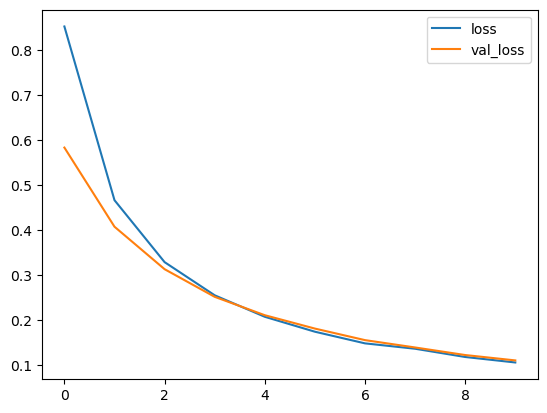

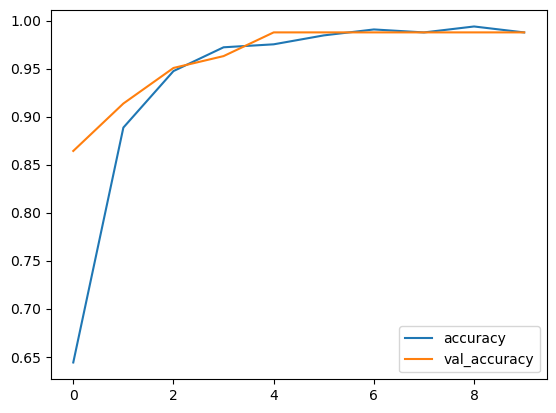

In [27]:
for metrics in [("loss", "val_loss"), ("accuracy", "val_accuracy")]:
    pd.DataFrame(history.history, columns=metrics).plot()
    plt.show()

## Evaluate the EfficientNet Model.

In [28]:
val_loss, val_acc = efficient_net_model.evaluate(valid_ds)
print(f"Validation Loss: {val_loss} Validation Accuracy: {val_acc}")

3/3 [==============================] - 1s 263ms/step - loss: 0.1095 - accuracy: 0.9877
Validation Loss: 0.10950890183448792 Validation Accuracy: 0.9876543283462524


## Conclusions
In this notebook, I created two kinds of video classification models: one using a Conv3D architecture and another based on a pretrained EfficientNet model (Transfer Learning). Transfer Learning can help boost the accuracy of video classification models when the training sample size is small. That's great!

## References
* https://www.tensorflow.org/tutorials/load_data/video